# Poisson Regression

Gaussian process models can be incredibly flexbile for modelling non-Gaussian data. One such example is in the case of count data $\mathbf{y}$, which can be modelled with a __Poisson model__ with a latent Gaussian process.
$$
\mathbf{y} \ | \ \mathbf{f} \sim \prod_{i=1}^{n} \frac{\lambda_i^{y_i}\exp\{-\lambda_i\}}{y_i!},
$$
where $\lambda_i=\exp(f_i)$ and $f_i$ is the latent Gaussian process.


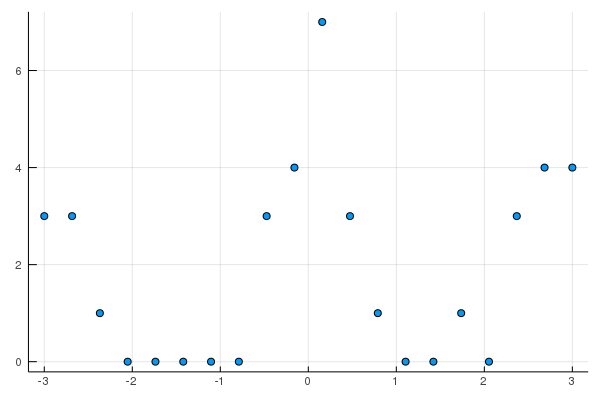

In [1]:
#Load the package
using GaussianProcesses, Random, Distributions

#Simulate the data
Random.seed!(203617)
n = 20
X = collect(range(-3,stop=3,length=n));
f = 2*cos.(2*X);
Y = [rand(Poisson(exp.(f[i]))) for i in 1:n];

#Plot the data using the Plots.jl package with the GR backend
using Plots
gr()
scatter(X,Y,leg=false, fmt=:png)

In [2]:
#GP set-up
k = Matern(3/2,0.0,0.0)   # Matern 3/2 kernel
l = PoisLik()             # Poisson likelihood
gp = GP(X, vec(Y), MeanZero(), k, l)

GP Monte Carlo object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat32Iso{Float64}, Params: [0.0, 0.0]
  Likelihood:
    Type: PoisLik, Params: Any[]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [3, 3, 1, 0, 0, 0, 0, 0, 3, 4, 7, 3, 1, 0, 0, 1, 0, 3, 4, 4]
  Log-posterior = -65.397

In [32]:
set_priors!(gp.kernel,[Normal(-2.0,4.0),Normal(-2.0,4.0)])
@time samples = mcmc(gp; nIter=100);

Number of iterations = 100, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 10.340000 
Number of function calls: 1035
Acceptance rate: 0.760000 
  0.053252 seconds (206.57 k allocations: 19.307 MiB, 22.74% gc time)


In [ ]:
#Sample predicted values
xtest = range(minimum(gp.x),stop=maximum(gp.x),length=50);
ymean = [];
fsamples = Array{Float64}(undef,size(samples,2), length(xtest));
for i in 1:size(samples,2)
    set_params!(gp,samples[:,i])
    update_target!(gp)
    push!(ymean, predict_y(gp,xtest)[1])
    fsamples[i,:] = rand(gp, xtest)
end

#Predictive plots

q10 = [quantile(fsamples[:,i], 0.1) for i in 1:length(xtest)]
q50 = [quantile(fsamples[:,i], 0.5) for i in 1:length(xtest)]
q90 = [quantile(fsamples[:,i], 0.9) for i in 1:length(xtest)]
plot(xtest,exp.(q50),ribbon=(exp.(q10), exp.(q90)),leg=true, fmt=:png, label="quantiles")
plot!(xtest,mean(ymean), label="posterior mean")
xx = range(-3,stop=3,length=1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")

In [6]:
using PDMats, LinearAlgebra
@time Q = vi(gp, nits=1000)

# gp.μ = Q.m
# gp.cK = PDMat(Q.V)



Number of iterations = 1, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 11.000000 
Number of function calls: 12
Acceptance rate: 1.000000 
  2.542951 seconds (19.61 M allocations: 2.201 GiB, 13.50% gc time)


GaussianProcesses.Approx([1.14727, 1.14896, 0.184949, -1.503, -1.51451, -1.52709, -1.54079, -1.55558, 1.15652, 1.42843, 1.96778, 1.15735, 0.173559, -1.66145, -1.68166, 0.166224, -1.72442, 1.15477, 1.42793, 1.42707], [0.0536892 0.0510801 … 0.00266458 -2.27356e5; 0.0510801 0.0486397 … 0.00255594 -227895.0; … ; 0.00266458 0.00255594 … 0.000169393 -2.33001e5; -2.27356e5 -227895.0 … -2.33001e5 -5.36799e-6])

In [34]:
temp

19×19 Array{Float64,2}:
 0.0536892   0.0510801   0.0484053   0.0456722   …  0.00539324   0.00266458 
 0.0510801   0.0486397   0.0461311   0.0435601      0.00517321   0.00255594 
 0.0484053   0.0461311   0.0437917   0.0413873      0.00494676   0.00244413 
 0.0456722   0.0435601   0.0413873   0.0391527      0.00471376   0.00232908 
 0.0428882   0.0409342   0.038924    0.0368565      0.00447408   0.00221074 
 0.0400606   0.0382609   0.0364093   0.0345048   …  0.0042276    0.00208904 
 0.0371967   0.0355475   0.0338507   0.0321053      0.00397417   0.00196391 
 0.034304    0.0328016   0.0312557   0.0296656      0.00371367   0.00183529 
 0.0313897   0.0300304   0.0286318   0.0271931      0.00344596   0.0017031  
 0.028461    0.0272414   0.0259865   0.0246955      0.00317088   0.00156729 
 0.0255254   0.024442    0.0233272   0.0221802   …  0.00288831   0.00142776 
 0.0225901   0.0216395   0.0206613   0.0196549      0.00259809   0.00128447 
 0.0196623   0.0188413   0.0179964   0.0171271      

In [35]:
# heatmap(temp)
Q.m

20-element Array{Float64,1}:
  1.147265487334234  
  1.1489625458534845 
  0.18494944933103516
 -1.5029961704198764 
 -1.514506582911446  
 -1.5270946675265746 
 -1.5407937748278089 
 -1.5555778057975786 
  1.1565193149696196 
  1.4284348895270136 
  1.9677800746066112 
  1.1573515238180905 
  0.173559102259826  
 -1.661449230475752  
 -1.681659196777475  
  0.16622357054689146
 -1.7244229378959497 
  1.1547706268769768 
  1.427926060666657  
  1.427069735367464  

In [22]:
temp = Q.V[1:(end-1), 1:(end-1)]
PDMat(temp + Array{Float64}(I, size(temp))*1e-6)

PDMat{Float64,Array{Float64,2}}(19, [0.0536902 0.0510801 … 0.00539324 0.00266458; 0.0510801 0.0486407 … 0.00517321 0.00255594; … ; 0.00539324 0.00517321 … 0.000688778 0.000341232; 0.00266458 0.00255594 … 0.000341232 0.000170393], Cholesky{Float64,Array{Float64,2}}([0.231712 0.220447 … 0.0232757 0.0114995; 0.0510801 0.00662587 … 0.00636268 0.00315392; … ; 0.00539324 0.00517321 … 0.00194789 0.000919369; 0.00266458 0.00255594 … 0.000341232 0.00114783], 'U', 0))

In [6]:
xtest = range(minimum(gp.x),stop=maximum(gp.x),length=50);
nsamps = 500
visamples = Array{Float64}(undef, nsamps, length(xtest));
ymean = [];
for i in 1:nsamps
    visamples[i,:] = rand(gp, xtest)
    push!(ymean, predict_y(gp, xtest)[1])
end

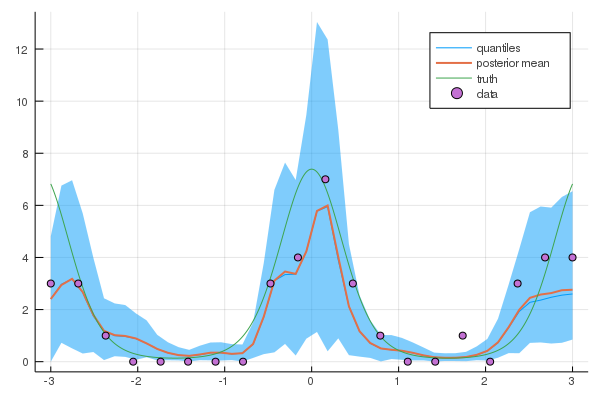

In [7]:
q10 = [quantile(visamples[:,i], 0.1) for i in 1:length(xtest)]
q50 = [quantile(visamples[:,i], 0.5) for i in 1:length(xtest)]
q90 = [quantile(visamples[:,i], 0.9) for i in 1:length(xtest)]
plot(xtest,exp.(q50),ribbon=(exp.(q10), exp.(q90)),leg=true, fmt=:png, label="quantiles")
plot!(xtest, mean(ymean), label="posterior mean", w=2)
xx = range(-3,stop=3,length=1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")
# savefig("vi.png")